## Tasks
1. Classify each video into one the 3 categories: 'Hot', 'Stable and Popular', 'Everything else'
2. What are the main characteristics of the "hot videos"?
3. how would you use this information from a product standpoint?

In [1]:
!ls -l

total 688
-rw-r--r--  1 parker  staff     921 Feb 20 14:33 online video.ipynb
-rw-r--r--@ 1 parker  staff  304718 Feb 20 14:33 online_videos.zip


In [2]:
!unzip online_videos.zip

Archive:  online_videos.zip
  inflating: video_count.csv         
  inflating: video_features.csv      


In [3]:
!cat video_count.csv |head -4

"video_id","count","date"
2303,22,"2015-01-07"
1193,54854,"2015-01-12"
1219,1788779,"2015-01-03"
cat: stdout: Broken pipe


In [4]:
!cat video_features.csv |head -4

"video_id","video_length","video_language","video_upload_date","video_quality"
2374,1760,"Cn","2014-12-06","480p"
1897,489,"Cn","2014-12-10","720p"
2386,1273,"Es","2014-12-05","480p"
cat: stdout: Broken pipe


In [9]:
!cat video_features.csv | wc -l
!cat video_count.csv | wc -l

    2786
   41776


In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
v_cnt = pd.read_csv("video_count.csv")
v_feature = pd.read_csv("video_features.csv")
v_df = pd.merge(left = v_cnt, right=v_feature, how='inner', on= 'video_id')
print("Merged df has shape: ", v_df.shape)
for col in ['date', 'video_upload_date']:
    v_df[col] = pd.to_datetime(v_df[col])
v_df['video_length'] /= 60
v_df.head(3)

Merged df has shape:  (41775, 7)


,video_id,count,date,video_length,video_language,video_upload_date,video_quality
0,2303,22,2015-01-07,17.85,Cn,2014-12-10,1080p
1,2303,21,2015-01-10,17.85,Cn,2014-12-10,1080p
2,2303,22,2015-01-01,17.85,Cn,2014-12-10,1080p


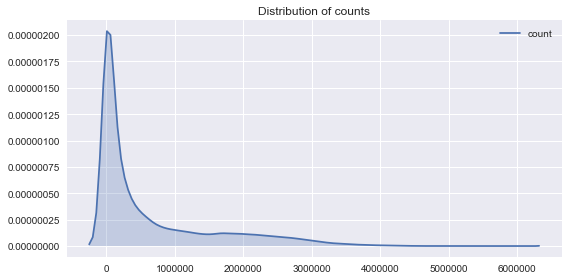

In [3]:
#some visualizations
#we see that most of the counts are within 1M
fig, ax = plt.subplots(figsize=(8,4))
sns.kdeplot(data = v_df['count'], shade = True, ax = ax)
ax.set_title("Distribution of counts")
plt.tight_layout()

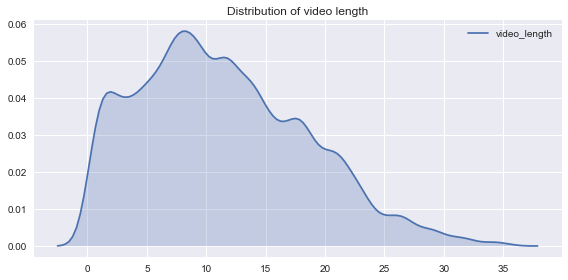

In [4]:
fig, ax = plt.subplots(figsize=(8,4))
sns.kdeplot(data = v_df['video_length'], shade = True, ax = ax)
ax.set_title("Distribution of video length")
plt.tight_layout()

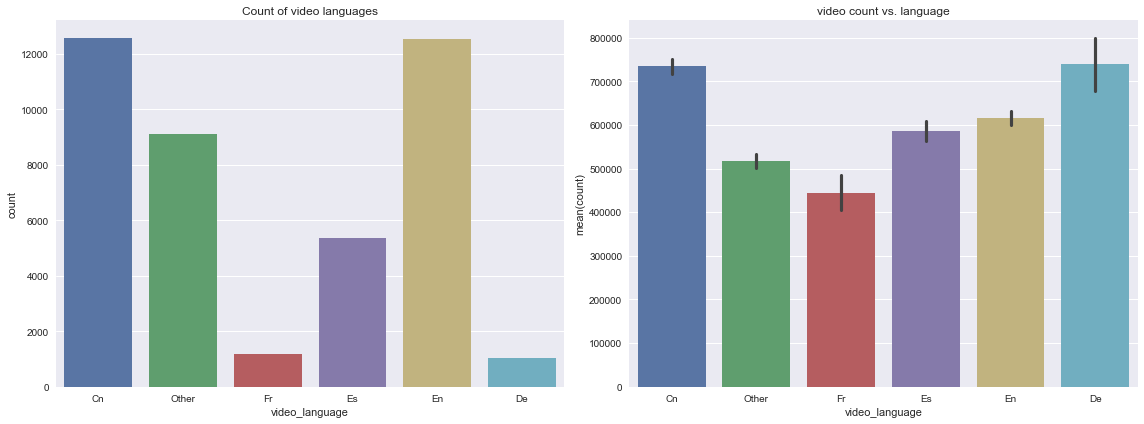

In [15]:
fig, ax = plt.subplots(ncols=2, figsize=(16,6))
sns.countplot(x = 'video_language', data = v_df, ax = ax[0])
ax[0].set_title("Count of video languages")
sns.barplot(x = 'video_language', y = 'count', data= v_df, ax= ax[1])
ax[1].set_title("video count vs. language")
plt.tight_layout()

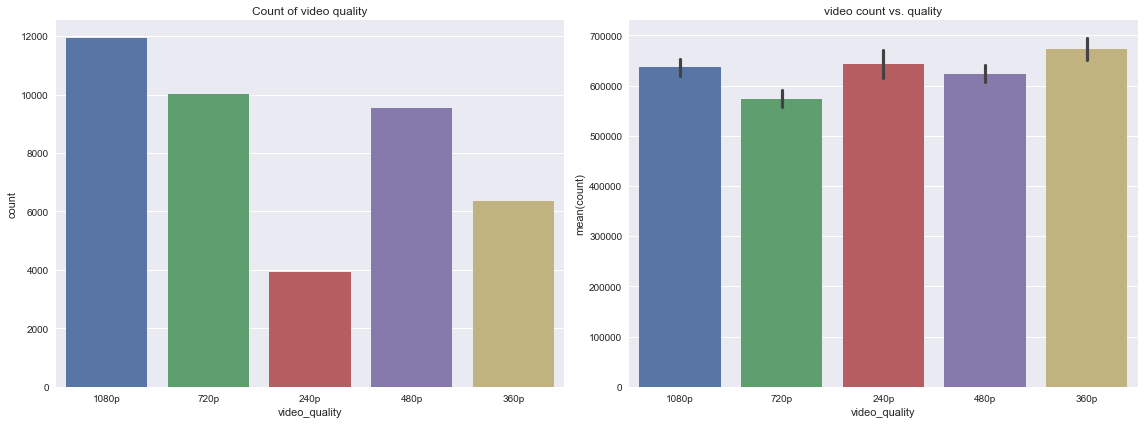

In [16]:
fig, ax = plt.subplots(ncols=2, figsize=(16,6))
sns.countplot(x = 'video_quality', data = v_df, ax = ax[0])
ax[0].set_title("Count of video quality")
sns.barplot(x = 'video_quality', y = 'count', data= v_df, ax= ax[1])
ax[1].set_title("video count vs. quality")
plt.tight_layout()

**1. classify each video to 1 of 3 categories**

Before classification, we need to first define hotness. Here I borrowed this great function from: https://github.com/JifuZhao/DS-Take-Home/blob/master/18.%20On-Line%20Video%20Challenge.ipynb

In [19]:
def parse_data(df):
    counts = df.sort_values(by = 'date')['count'].values
    change = (counts[1:] - counts[:-1])/counts[:-1]
    
    index = ['ct_mean', 'ct_std', 'ct_min', 'ct_25%', 'ct_50%', 'ct_75%', 'ct_max', 
             'cg_mean', 'cg_std', 'cg_min', 'cg_25%', 'cg_50%', 'cg_75%', 'cg_max']
    
    ct_vals = pd.Series(counts).describe()
    cg_vals = pd.Series(change).describe()
    
    ct_values = [ct_vals['mean'], ct_vals['std'], ct_vals['min'], ct_vals['25%'], 
                 ct_vals['50%'], ct_vals['75%'], ct_vals['max']]
    cg_values = [cg_vals['mean'], cg_vals['std'], cg_vals['min'], cg_vals['25%'], 
                 cg_vals['50%'], cg_vals['75%'], cg_vals['max']]
    return pd.Series(ct_values + cg_values, index = index)

data_stats = v_df.groupby('video_id').apply(parse_data)
data_stats.head()

,ct_mean,ct_std,ct_min,ct_25%,ct_50%,ct_75%,ct_max,cg_mean,cg_std,cg_min,cg_25%,cg_50%,cg_75%,cg_max
video_id,,,,,,,,,,,,,,
1,7.063560e+04,39200.460092,19382.0,41099.0,65907.0,96335.0,140460.0,-0.127437,0.092392,-0.271522,-0.186381,-0.151384,-0.067977,0.030277
2,1.737141e+06,114254.355156,1550493.0,1673415.5,1718352.0,1782226.5,2011096.0,-0.014184,0.061794,-0.084904,-0.061459,-0.043876,0.030687,0.095038
3,2.292781e+06,218636.897779,2016210.0,2132336.5,2247587.0,2436222.5,2653063.0,0.008923,0.054069,-0.075863,-0.028293,-0.001068,0.056393,0.097053
4,2.740392e+06,169611.440727,2474228.0,2611162.0,2719547.0,2880268.5,2984146.0,0.011310,0.050495,-0.063991,-0.027125,0.001606,0.050860,0.090804
5,4.479973e+05,237137.305768,169730.0,255574.5,388594.0,609508.0,983058.0,-0.111811,0.107193,-0.269337,-0.177432,-0.133447,-0.012729,0.031766


/Users/parker/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


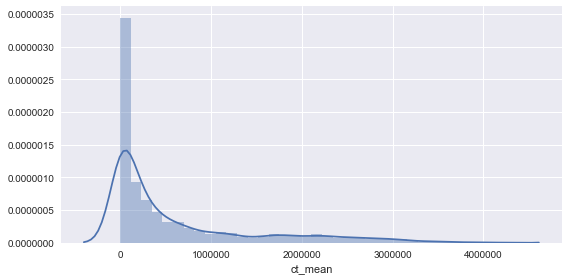

In [20]:
#popularity
fig, ax = plt.subplots(figsize = (8,4))
sns.distplot(data_stats['ct_mean'], ax = ax)
plt.tight_layout()

Here, we define *'stable and popular'* videos as those whose mean value is greater than 1.5M(a randomly chosen threshold)

In [25]:
popular_videos = data_stats[data_stats['ct_mean'] > 1500000]
popular_videos.head()

,ct_mean,ct_std,ct_min,ct_25%,ct_50%,ct_75%,ct_max,cg_mean,cg_std,cg_min,cg_25%,cg_50%,cg_75%,cg_max
video_id,,,,,,,,,,,,,,
2,1.737141e+06,114254.355156,1550493.0,1673415.5,1718352.0,1782226.5,2011096.0,-0.014184,0.061794,-0.084904,-0.061459,-0.043876,0.030687,0.095038
3,2.292781e+06,218636.897779,2016210.0,2132336.5,2247587.0,2436222.5,2653063.0,0.008923,0.054069,-0.075863,-0.028293,-0.001068,0.056393,0.097053
4,2.740392e+06,169611.440727,2474228.0,2611162.0,2719547.0,2880268.5,2984146.0,0.011310,0.050495,-0.063991,-0.027125,0.001606,0.050860,0.090804
8,2.049360e+06,157190.210173,1776574.0,1950028.5,2042499.0,2154066.5,2328022.0,0.004013,0.055904,-0.090772,-0.034195,0.009304,0.046501,0.081409
14,1.593414e+06,249941.247042,1301816.0,1380598.0,1502636.0,1793568.0,2056101.0,-0.011086,0.063787,-0.095199,-0.074206,-0.005127,0.049045,0.092254


For hot videos, we need to take a look at their daily change rate. Based on below density plot, we see a clear threshold at 0.2, and we define *hot* videos to be those whose daily change rate > 0.2

/Users/parker/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


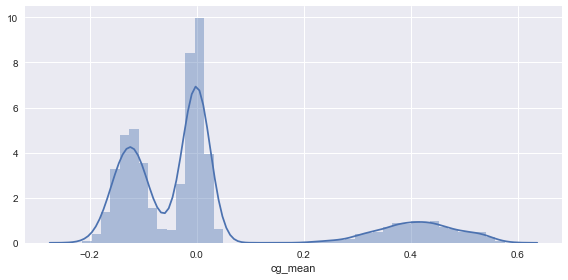

In [23]:
fig, ax = plt.subplots(figsize = (8,4))
sns.distplot(data_stats['cg_mean'], ax = ax)
plt.tight_layout()

In [26]:
hot_videos = data_stats[data_stats['cg_mean'] > 0.2]
hot_videos.head()

,ct_mean,ct_std,ct_min,ct_25%,ct_50%,ct_75%,ct_max,cg_mean,cg_std,cg_min,cg_25%,cg_50%,cg_75%,cg_max
video_id,,,,,,,,,,,,,,
10,8903.133333,10248.629782,591.0,1882.5,5483.0,11318.5,34789.0,0.353819,0.220112,0.006865,0.238332,0.324975,0.416434,0.780195
13,91228.200000,91574.506421,4746.0,16688.0,45930.0,153985.5,264570.0,0.350798,0.223287,-0.000643,0.171082,0.373361,0.514471,0.629066
15,6184.400000,9384.882059,494.0,1190.0,1705.0,6231.5,33208.0,0.381382,0.313682,-0.048170,0.026856,0.471749,0.656678,0.740953
28,105011.600000,132346.803029,6152.0,14399.0,30084.0,152599.5,405278.0,0.367767,0.239208,-0.045739,0.206640,0.300966,0.502638,0.778389
29,78372.866667,70559.053747,9118.0,16789.5,45226.0,131717.0,212419.0,0.271285,0.228626,-0.028478,0.046231,0.293353,0.455947,0.665369


**2. Characteristics of hot videos**

In [28]:
v_df['hot'] = False
v_df.loc[v_df.index.isin(hot_videos.index), 'hot'] = True
v_df.head()

,video_id,count,date,video_length,video_language,video_upload_date,video_quality,hot
0,2303,22,2015-01-07,17.85,Cn,2014-12-10,1080p,False
1,2303,21,2015-01-10,17.85,Cn,2014-12-10,1080p,False
2,2303,22,2015-01-01,17.85,Cn,2014-12-10,1080p,False
3,2303,21,2015-01-09,17.85,Cn,2014-12-10,1080p,False
4,2303,22,2015-01-11,17.85,Cn,2014-12-10,1080p,False


/Users/parker/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/parker/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


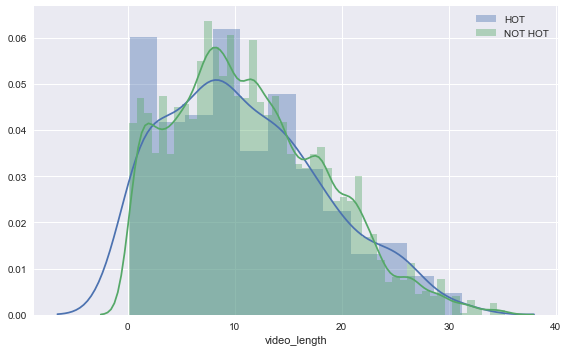

In [31]:
#look at video length characteristic
fig, ax = plt.subplots(figsize = (8,5))
sns.distplot(v_df.loc[v_df['hot'] == True, 'video_length'], label='HOT', ax = ax)
sns.distplot(v_df.loc[v_df['hot'] == False, 'video_length'], label = 'NOT HOT', ax = ax)
ax.legend(fontsize = 10)
plt.tight_layout()

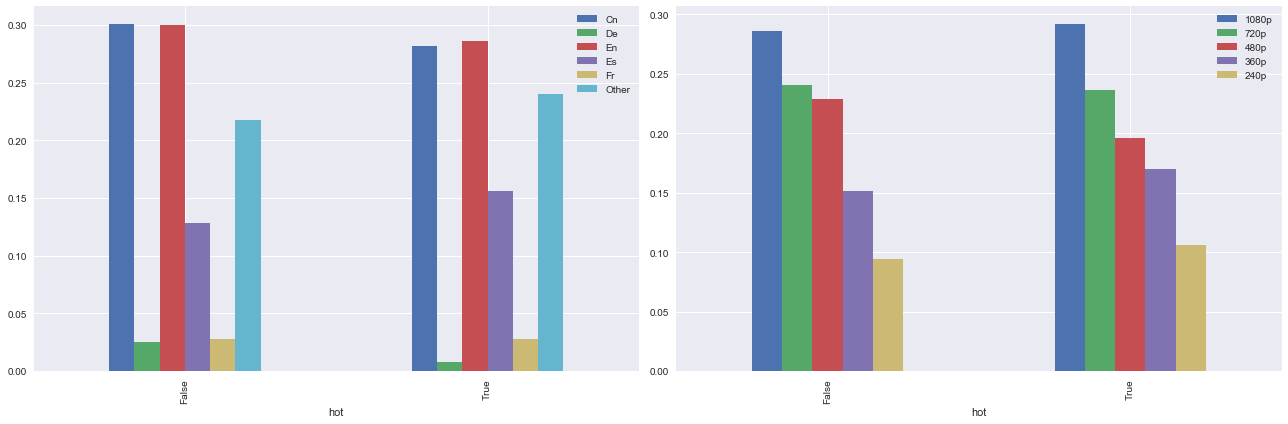

In [45]:
#look at language and quality characteristic
#For hot videos, there are more ES and less DE; there are less 480p and more 240p
fig, ax = plt.subplots(ncols = 2, figsize = (18,6))
language_df = v_df.groupby('hot')['video_language'].apply(lambda x: x.value_counts(normalize = True)).unstack()
language_df.plot(kind = 'bar', ax = ax[0])
quality_df = v_df.groupby('hot')['video_quality'].apply(lambda x:x.value_counts(normalize = True)).unstack()
quality_df.plot(kind = 'bar', ax=ax[1])
plt.tight_layout()

**3. what to do next**
- build a classification model
- analyze certain characteristics